In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Load Data
print("Loading data...")
train_df = pd.read_csv('../data/activity_train.csv')
test_df = pd.read_csv('../data/activity_test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# 2. Identify Target and Features
# Usually the target column is named 'Activity' or 'label'
target_col = 'Activity' if 'Activity' in train_df.columns else train_df.columns[-1]
print(f"Target column identified as: '{target_col}'")

# Separate X (Features) and y (Target)
# We also drop 'subject' if it exists, as it's not a sensor feature
drop_cols = [target_col]
if 'subject' in train_df.columns:
    drop_cols.append('subject')

X_train = train_df.drop(columns=drop_cols)
y_train_raw = train_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test_raw = test_df[target_col]

# 3. Encode Labels (Strings -> Numbers)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# 4. Scale Data (Critical for K-NN, helpful for others)
# This keeps the column names which is important for your Q1 analysis
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Data processing complete.")

Loading data...
Train shape: (7767, 562)
Test shape: (3162, 562)
Target column identified as: 'activity'
Data processing complete.


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import time

# Dictionary to store our best models
models = {}

# --- 1. K-Nearest Neighbors ---
print("Training K-NN...")
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 7, 11], 'weights': ['uniform', 'distance']}
# n_iter=3 means we only try 3 random combinations. Fast.
knn_search = RandomizedSearchCV(knn, knn_params, n_iter=3, cv=3, n_jobs=-1, random_state=42)
knn_search.fit(X_train_scaled, y_train)
models['KNN'] = knn_search.best_estimator_

# --- 2. Random Forest ---
print("Training Random Forest...")
# Limiting n_estimators to 100 prevents long runtimes
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {'n_estimators': [50, 100], 'max_depth': [10, None]}
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=3, cv=3, n_jobs=-1, random_state=42)
rf_search.fit(X_train_scaled, y_train)
models['RF'] = rf_search.best_estimator_

# --- 3. XGBoost ---
print("Training XGBoost...")
# tree_method='hist' is the "Fast" mode for XGBoost
xgb = XGBClassifier(eval_metric='mlogloss', tree_method='hist', random_state=42)
xgb_params = {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.3], 'max_depth': [3, 6]}
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=3, cv=3, n_jobs=-1, random_state=42)
xgb_search.fit(X_train_scaled, y_train)
models['XGB'] = xgb_search.best_estimator_

# --- 4. CatBoost ---
print("Training CatBoost...")
# iterations=100 is low, but enough for this dataset
cb = CatBoostClassifier(verbose=0, allow_writing_files=False, random_state=42)
cb_params = {'iterations': [100, 200], 'depth': [4, 6], 'learning_rate': [0.1]}
cb_search = RandomizedSearchCV(cb, cb_params, n_iter=2, cv=3, n_jobs=-1, random_state=42)
cb_search.fit(X_train_scaled, y_train)
models['CatBoost'] = cb_search.best_estimator_

print("\nAll models trained! Current Accuracies:")
for name, model in models.items():
    print(f"{name}: {model.score(X_test_scaled, y_test):.4f}")

Training K-NN...
Training Random Forest...
Training XGBoost...
Training CatBoost...

All models trained! Current Accuracies:
KNN: 0.8703
RF: 0.9070
XGB: 0.9399
CatBoost: 0.8991


Time features: 272
Freq features: 289

Running subset comparison...
Time-Domain Only: 0.8906
Freq-Domain Only: 0.8571
Combined (All): 0.9048


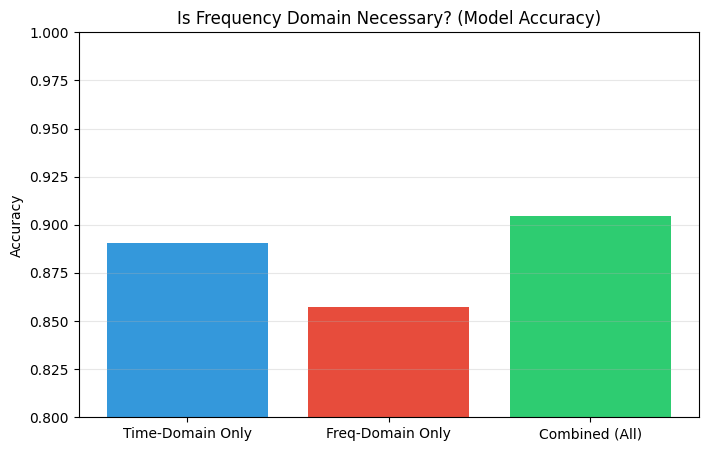

In [3]:
# Filter column names based on prefix
t_cols = [c for c in X_train.columns if c.startswith('t')]
f_cols = [c for c in X_train.columns if c.startswith('f')]

print(f"Time features: {len(t_cols)}")
print(f"Freq features: {len(f_cols)}")

# Define the subsets
subsets = {
    "Time-Domain Only": t_cols,
    "Freq-Domain Only": f_cols,
    "Combined (All)": X_train.columns
}

# We use a simple Random Forest to test the subsets
tester_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
results_q1 = {}

print("\nRunning subset comparison...")
for name, cols in subsets.items():
    # Train on subset
    tester_model.fit(X_train_scaled[cols], y_train)
    # Test on subset
    acc = tester_model.score(X_test_scaled[cols], y_test)
    results_q1[name] = acc
    print(f"{name}: {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(results_q1.keys(), results_q1.values(), color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylim(0.8, 1.0) # Zoom in to see small differences
plt.title("Is Frequency Domain Necessary? (Model Accuracy)")
plt.ylabel("Accuracy")
plt.grid(axis='y', alpha=0.3)
plt.show()

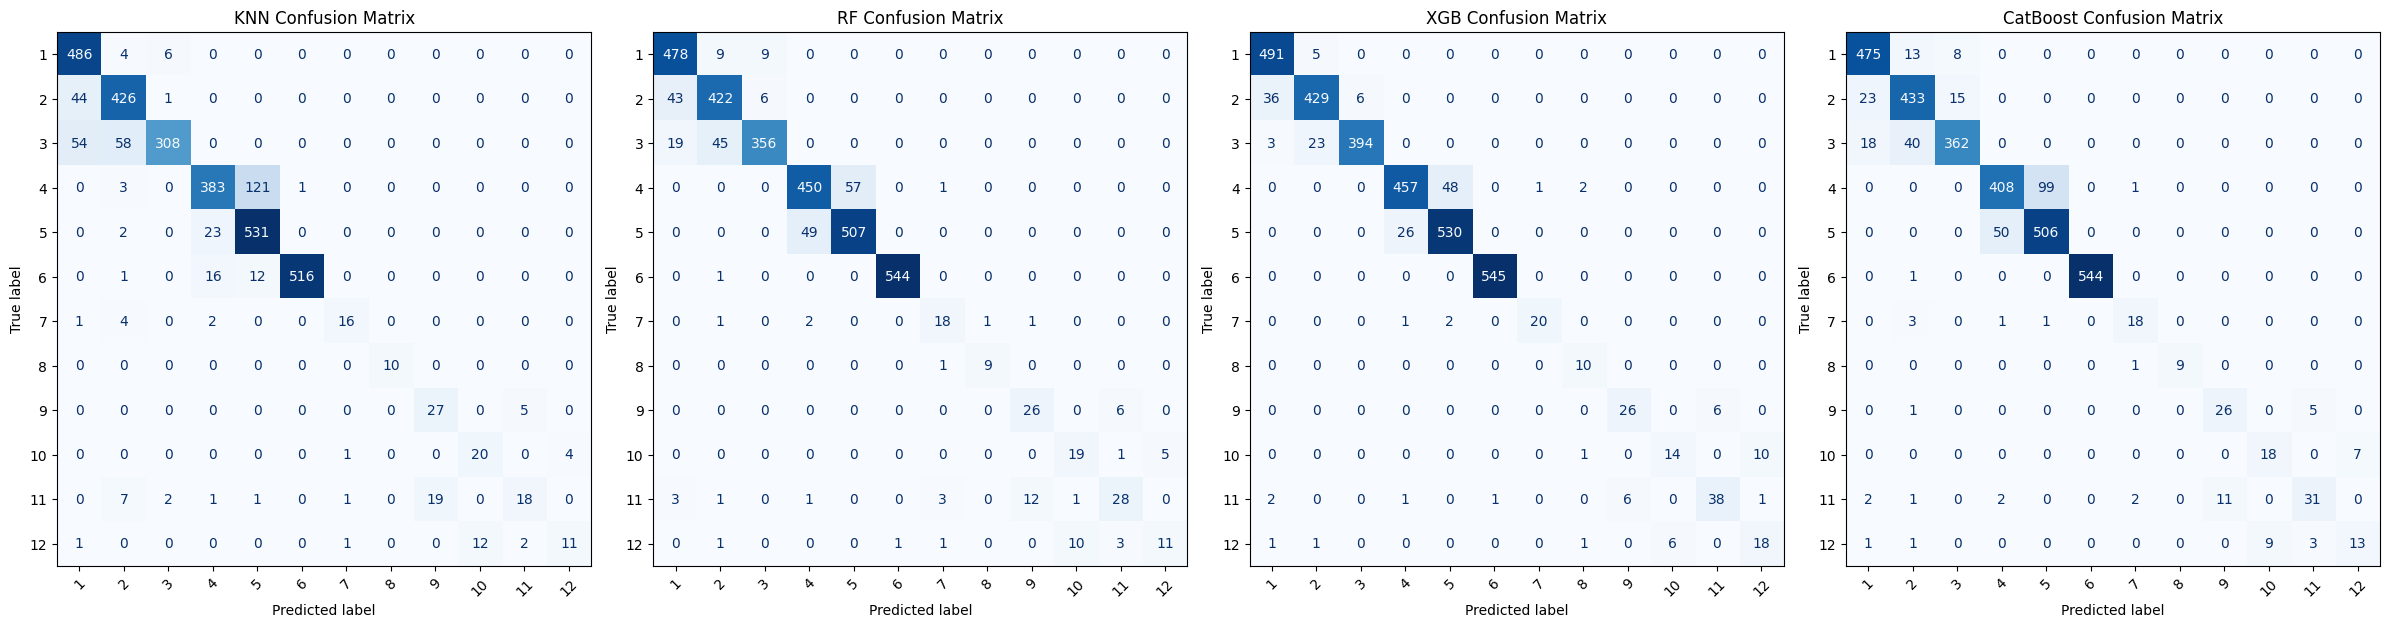

INSIGHT CHECK:
Look at the Confusion Matrices above.
The diagonal blocks are correct predictions.
The off-diagonal squares show errors.
Common Issue: 'SITTING' vs 'STANDING'.
Check which model has the least confusion between those two specific classes.


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set up the plot area
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
model_names = ['KNN', 'RF', 'XGB', 'CatBoost']

for i, name in enumerate(model_names):
    # Get predictions
    preds = models[name].predict(X_test_scaled)
    
    # Create Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    
    # Display it
    # We use le.classes_ to show the actual activity names (WALKING, SITTING, etc.)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False, xticks_rotation=45)
    axes[i].set_title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

# Quick Insight Generator
print("INSIGHT CHECK:")
print("Look at the Confusion Matrices above.")
print("The diagonal blocks are correct predictions.")
print("The off-diagonal squares show errors.")
print("Common Issue: 'SITTING' vs 'STANDING'.") 
print("Check which model has the least confusion between those two specific classes.")

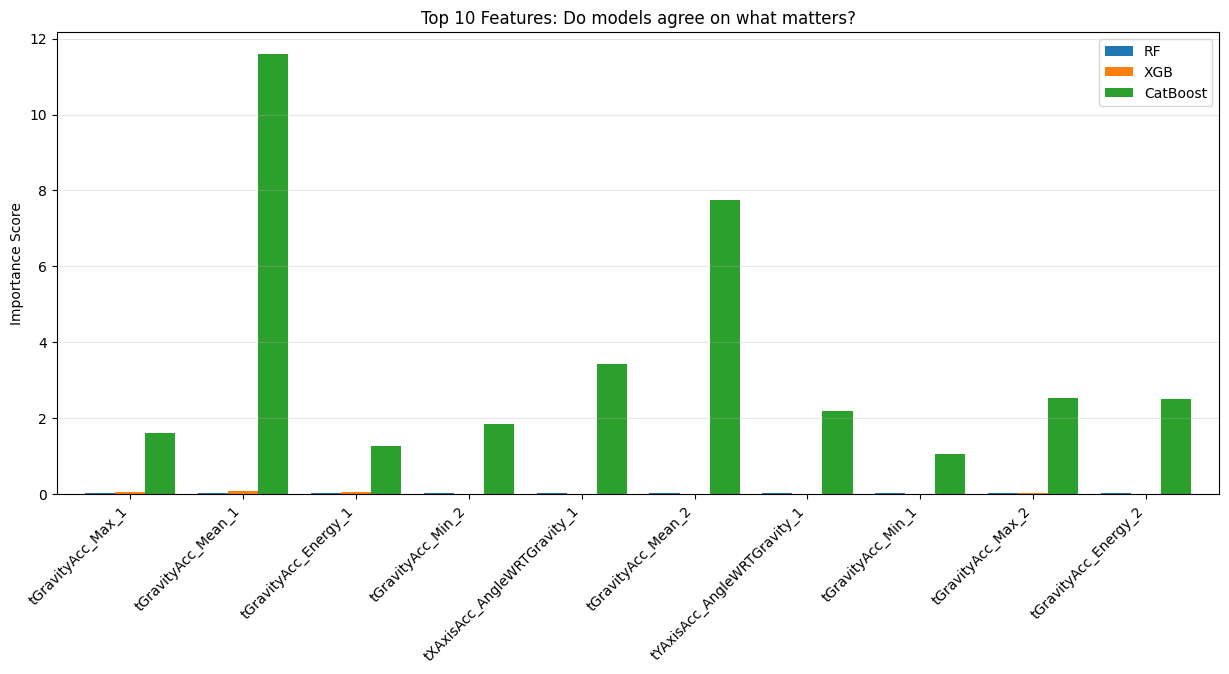

In [5]:
# Create a dataframe of feature importances
importances = pd.DataFrame(index=X_train.columns)

# KNN doesn't have "feature importance", so we skip it here
importances['RF'] = models['RF'].feature_importances_
importances['XGB'] = models['XGB'].feature_importances_
importances['CatBoost'] = models['CatBoost'].feature_importances_

# Sort by RF importance to organize the chart
importances_sorted = importances.sort_values(by='RF', ascending=False).head(10)

# Plot
importances_sorted.plot(kind='bar', figsize=(15, 6), width=0.8)
plt.title("Top 10 Features: Do models agree on what matters?")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()